#Figure 8 supplement 1 - Functional imaging

This notebook loads in the data corresponding to figure 8 supplement 1

We then computes the mean intenstity image 8_1A), the local correlation image 8_1B)

## Setup plotting

In [3]:
from showit import image
%matplotlib inline

In [27]:
import seaborn as sns
sns.set_context('paper', font_scale=2.0)
sns.set_style('ticks')

In [2]:
from skimage.io import imsave

##Loading in the data

In [82]:
path = '/tier2/freeman/Nick/2pRAM.paper/02'

In [83]:
from thunder.images import frombinary

data = frombinary(path + '/images', engine=sc)

##Detrend timeseries

In [84]:
from numpy import arange, polyfit, polyval

def detrend(y, order=5):
    x = arange(len(y))
    p = polyfit(x, y, order)
    p[-1] = 0
    yy = polyval(p, x)
    return y - yy

In [85]:
detrended = data.map_as_series(detrend, block_size = '10')
detrended.cache()

Images
mode: spark
dtype: float64
shape: (4044, 1682, 1792)

## Compute and inspect the mean image

In [17]:
mean = detrended.mean().toarray()

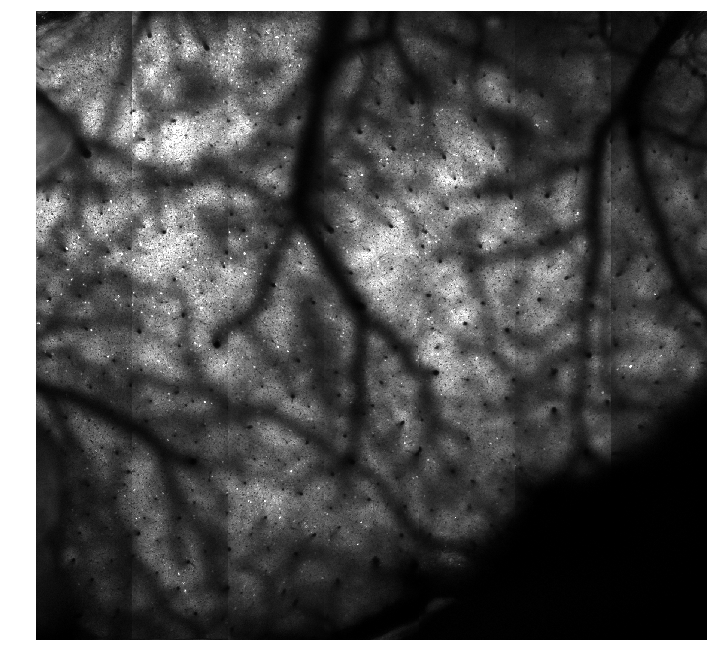

In [18]:
image(mean, clim=(0, 1000), size = 12);

In [13]:
imsave(path + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

## Compute and inspect local correlation image

In [8]:
localcorr = detrended.localcorr(4)

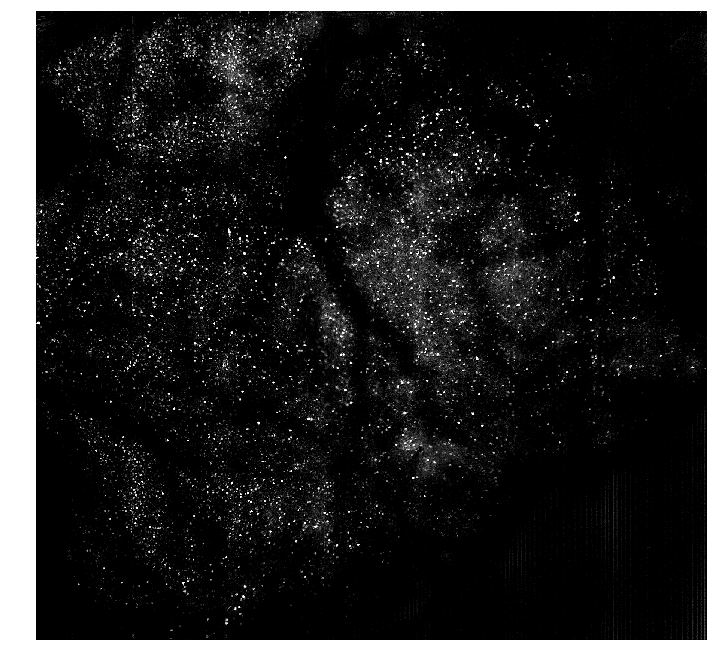

In [16]:
image(localcorr, clim=(0.3, 0.7), size = 12);

In [17]:
imsave(path + '/summary/localcorr.tif', localcorr.astype('float32'), plugin='tifffile', photometric='minisblack')

##Display sources

In [9]:
from json import load
from regional import many

with open(path + '/sources/sources.json') as dataFile:
    s = load(dataFile)
regions = many([x['coordinates'] for x in s])

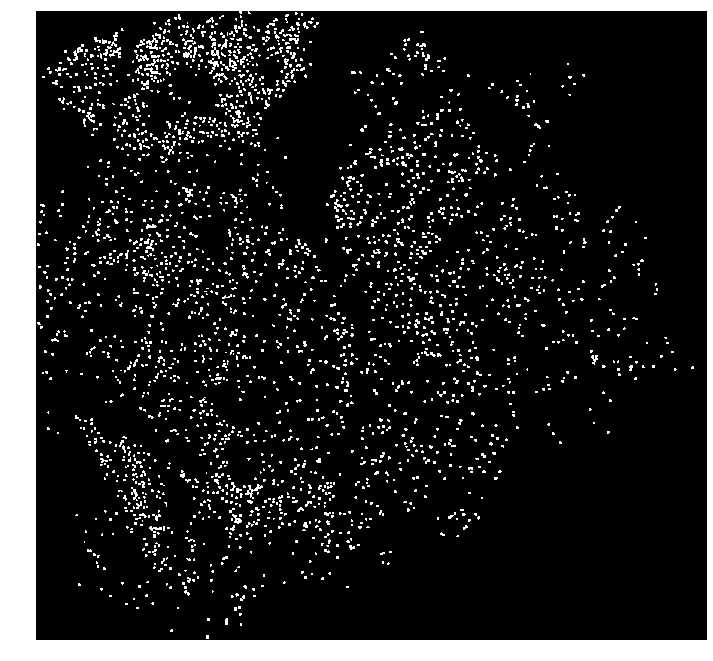

In [13]:
sources = regions.mask(dims=mean.shape, background = 'black', fill = 'white')[:,:,0]
image(sources, size = 12);

In [14]:
imsave(path + '/summary/sources.tif', sources.astype('float32'), plugin='tifffile', photometric='minisblack')

##Compute and inspect neuron activity traces

In [19]:
from extraction.model import ExtractionModel

em = ExtractionModel(regions)
traces = em.transform(detrended).normalize('window', window=500).tolocal()
traces.tobinary(path + '/traces', overwrite = True)

In [8]:
from numpy import array
time = array([float(x)/1.96 for x in range(traces[0].shape[1])])

In [75]:
# select the 100 neurons with the largest skew
from scipy.stats import skew

skews = skew(traces.values[:,300*1.9:1.9*600],axis=1)
ids = skews.argsort()[-100:]

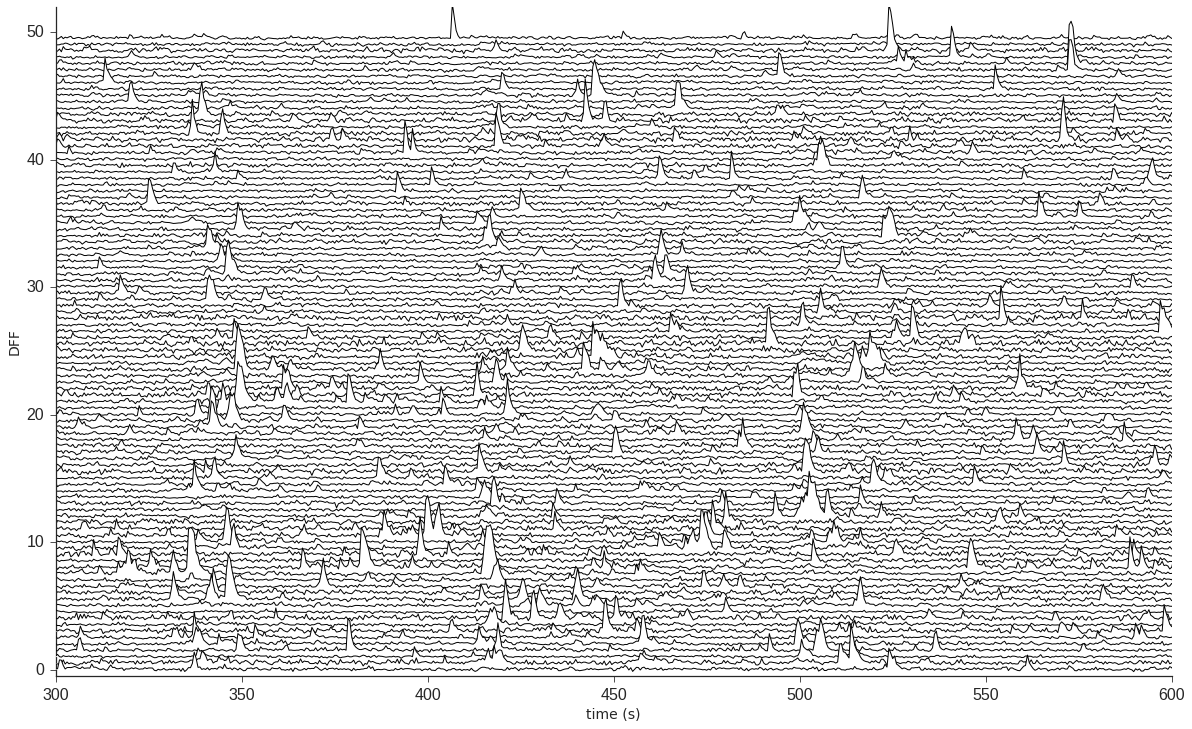

In [80]:
from matplotlib.pyplot import plot, xlim, ylim, xlabel, ylabel, figure, fill_between, savefig 

figure(figsize = (20,12))

for i in range(len(ids)):
    fill_between(time, i/2.0, i/2.0+traces[ids[i]].values.T.squeeze(), zorder=20 - 2*i, closed=False,  lw = 0, facecolor = 'white', edgecolor = 'white');
    plot(time, i/2.0 + traces[ids[i]].values.T, lw = 1, zorder=20 - (2*i-1), color = 'k');

xlabel('time (s)', fontsize=14);
xlim([300, 600])
ylim([-0.5, 52])
ylabel('DFF', fontsize=14);
sns.despine()
savefig(path + '/summary/traces.eps')

##Smooth and downsample in time for movie

In [ ]:
from numpy import convolve, ones

def smooth(s, ds):
    r = convolve(s, ones(ds)/ds, 'same').astype('int16')
    return r[::ds]

smoothed = detrended.map_as_series(lambda x: smooth(x, 2), block_size = 10)
# Save smoothed data
#smoothed.tobinary(path + '/downsampled', overwrite = True)